In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from torchvision import datasets, transforms

import helper

In [ ]:
!pip uninstall helper

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**LOADING DATA**

In [74]:
from torch.utils.data.sampler import SubsetRandomSampler

data_dir = 'Cat_Dog_data'
batch_size = 20
# Percentage of validation set
valid_size = 0.2

transform = transforms.Compose([transforms.Resize(128),
                                transforms.CenterCrop(128),
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5],
                                                    [0.5,0.5,0.5])])

train_data = datasets.ImageFolder(data_dir + '/train', transform=transform)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transform)


num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[:split], indices[split:]

# Defining Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

classes = ['CAT', 'DOG']

**CHECKING LOADED DATA**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([20, 3, 128, 128])


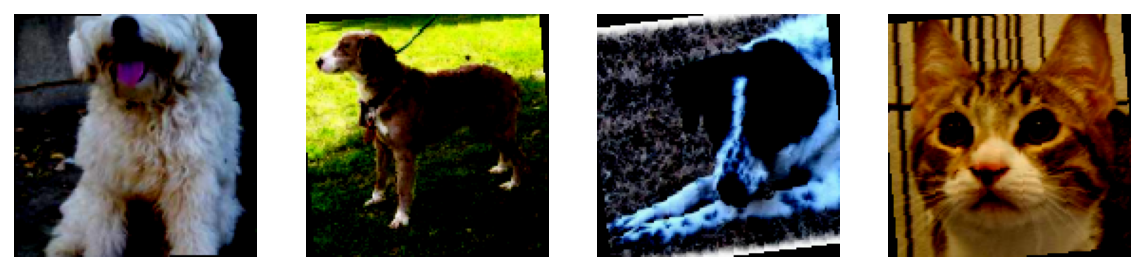

In [66]:
data_iter = iter(valid_loader)

images, labels = next(data_iter)
print(images.shape)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)

for i in range(4):
    ax = axes[i]
    helper.imshow(images[i], ax=ax, normalize=False)

**DEFINING MODEL ARCHITECTURE**

In [67]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # 1st Conv Layer (128*128*3)
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        # 2nd Conv Layer (32*32*32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        # 3rd Conv Layer (8*8*64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        
        
        #MaxPooling Layer
        self.pool = nn.MaxPool2d(4,4)
        
        # 1st Linear Layer (2*2*128 --> 250 )
        self.fc1 = nn.Linear(2*2*128, 250)
        # 2nd Linear Layer (2*2*128 --> 250 )
        self.fc2 = nn.Linear(250, 2)
        
        # Dropout Layer
        self.dropout = nn.Dropout(p=0.4)
        
    def forward(self, x):
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        # Faltten Image
        x = x.view(-1, 2*2*128)
        
        x = self.dropout(F.relu(self.fc1(x)))
        x = F.log_softmax(self.fc2(x), dim=1)
        
        return x
    
model = Net()
print(model)

model.to(device)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)


Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=250, bias=True)
  (fc2): Linear(in_features=250, out_features=2, bias=True)
  (dropout): Dropout(p=0.4, inplace=False)
)

In [68]:
import torch.optim as optim

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

**TRAINING THE MODEL**

In [69]:
epochs = 8

valid_loss_min = np.Inf 

for e in range(epochs):
    
    # Tracking Validation and training loss
    train_loss = 0.0
    valid_loss = 0.0
    
    #################TRAINING MODEL###############
    model.train()
    for features, label in train_loader:
        # if GPU available then train using GPU else CPU
        features, label = features.to(device), label.to(device)
        
        optimizer.zero_grad()
        
        output = model(features)
        #Calculating Loss
        loss = criterion(output, label)
        # BackProp
        loss.backward()
        # Upadting weights
        optimizer.step()
        
        # Training Loss multiplying with 3 for RGB
        train_loss += loss.item()*features.size(0)
        
    ###############VALIDATE MODEL#################
    model.eval()
    for features, label in valid_loader:
        features, label = features.to(device), label.to(device)
        
        output = model(features)
        loss = criterion(output, label)
        # Validation Loss
        valid_loss += loss.item()*features.size(0)
        
    # Calculating Average Losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Printing Stats
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, train_loss, valid_loss))
    
    # Save Model if valid_loss min
    if valid_loss <= valid_loss_min:
        print('Validation Loss decreased ({:.6f} ---> {:.6f}). Saving Model.........'.format(
            valid_loss_min, valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.674883 	Validation Loss: 0.638008
Validation Loss decreased (inf ---> 0.638008). Saving Model.........
Epoch: 2 	Training Loss: 0.611685 	Validation Loss: 0.574153
Validation Loss decreased (0.638008 ---> 0.574153). Saving Model.........
Epoch: 3 	Training Loss: 0.552893 	Validation Loss: 0.543033
Validation Loss decreased (0.574153 ---> 0.543033). Saving Model.........
Epoch: 4 	Training Loss: 0.515365 	Validation Loss: 0.520918
Validation Loss decreased (0.543033 ---> 0.520918). Saving Model.........
Epoch: 5 	Training Loss: 0.492553 	Validation Loss: 0.516080
Validation Loss decreased (0.520918 ---> 0.516080). Saving Model.........
Epoch: 6 	Training Loss: 0.466436 	Validation Loss: 0.484099
Validation Loss decreased (0.516080 ---> 0.484099). Saving Model.........
Epoch: 7 	Training Loss: 0.440041 	Validation Loss: 0.463410
Validation Loss decreased (0.484099 ---> 0.463410). Saving Model.........
Epoch: 8 	Training Loss: 0.407745 	Validation Loss: 0.454486

In [75]:
# track test loss
test_loss = 0.0
class_correct = [0.0, 0.0]
class_total = [0.0, 0.0]

model.eval()
# iterate over test data
for features, label in test_loader:
    # move tensors to GPU if CUDA is available
    features, label = features.to(device), label.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(features)
    # calculate the batch loss
    loss = criterion(output, label)
    # update test loss 
    test_loss += loss.item()*features.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(label.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        l = label.data[i]
        class_correct[l] += correct[i].item()
        class_total[l] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.465108

Test Accuracy of   CAT: 82% (1032/1250)
Test Accuracy of   DOG: 76% (957/1250)

Test Accuracy (Overall): 79% (1989/2500)


/home/ankur/Desktop/ML/Practice/helper.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


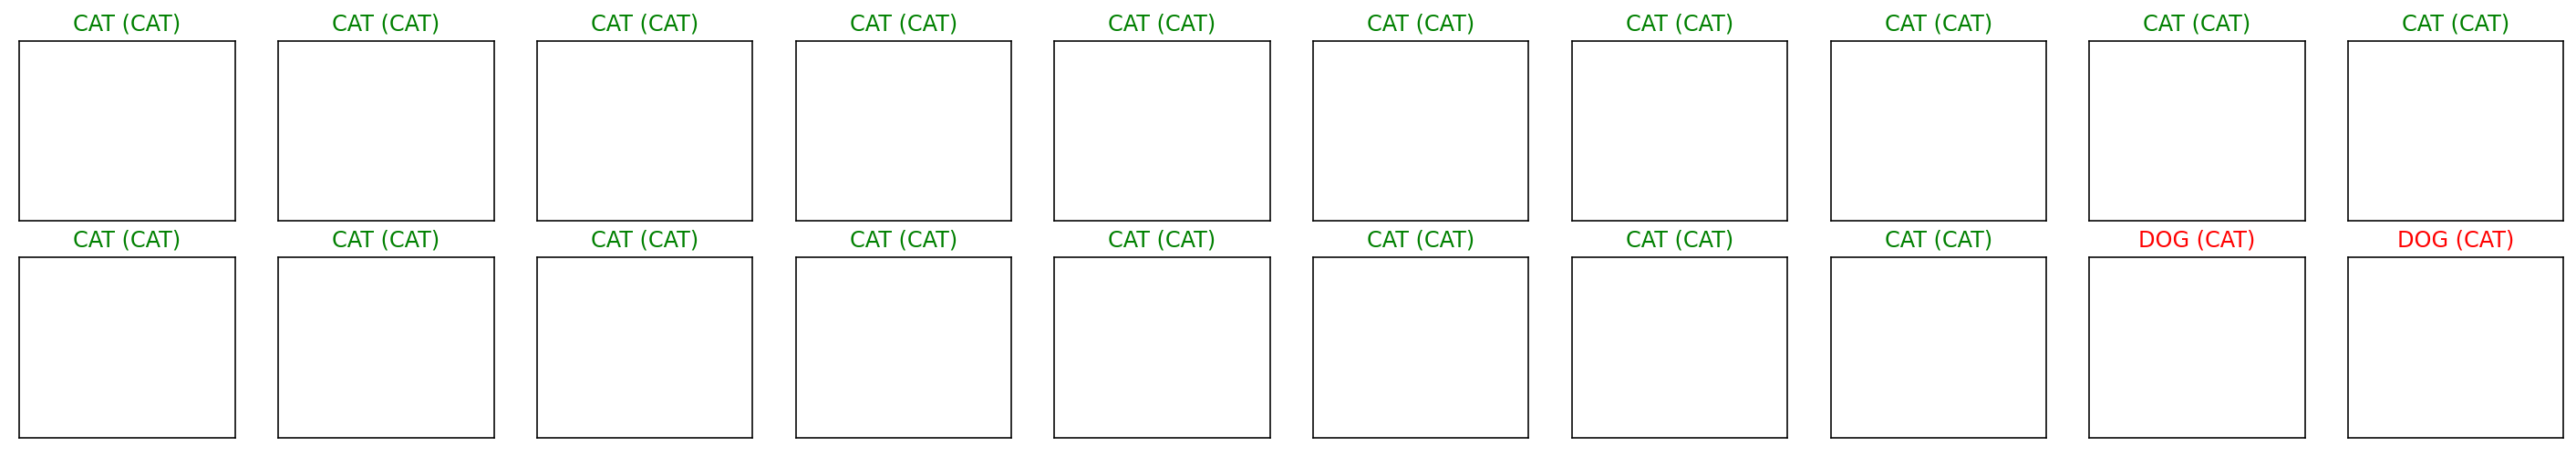

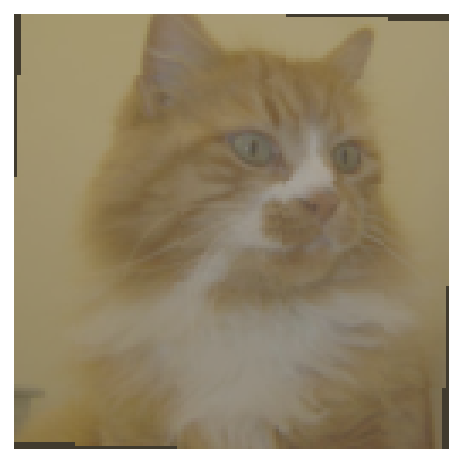

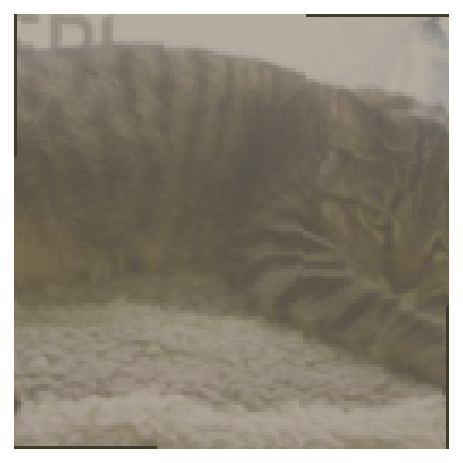

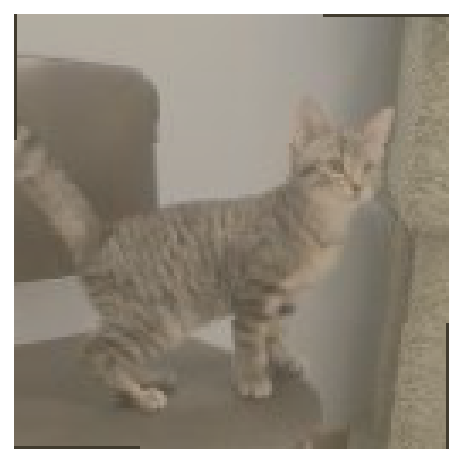

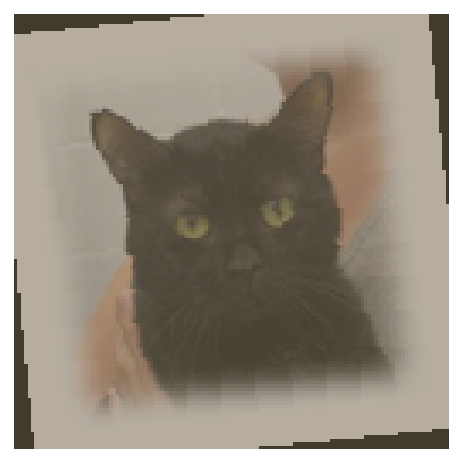

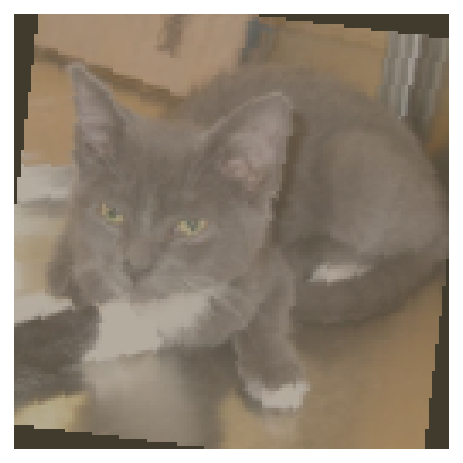

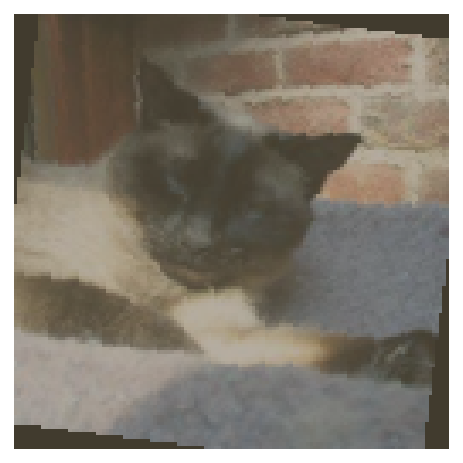

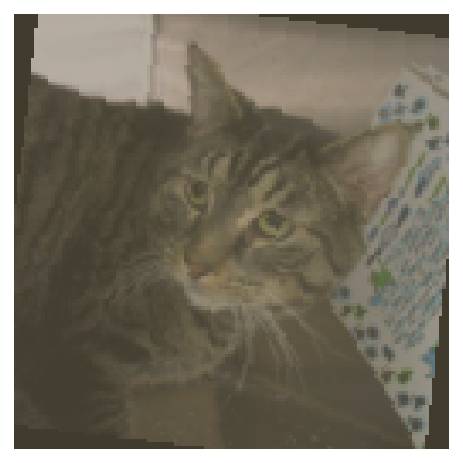

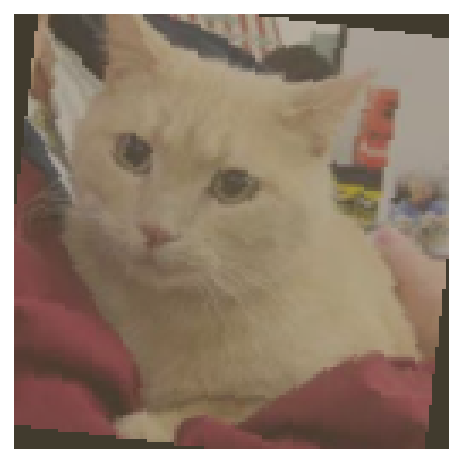

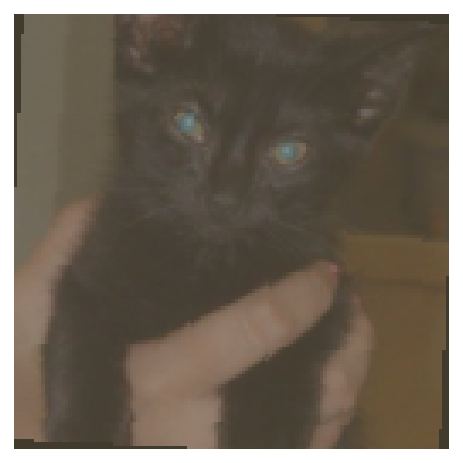

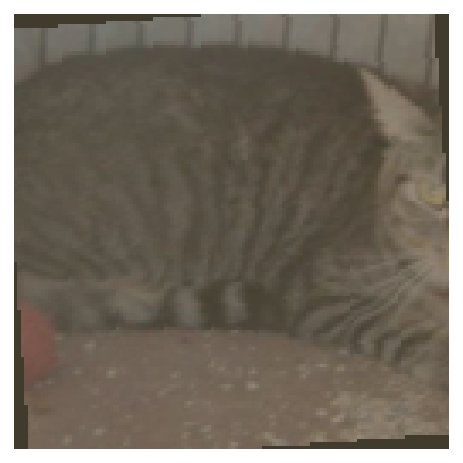

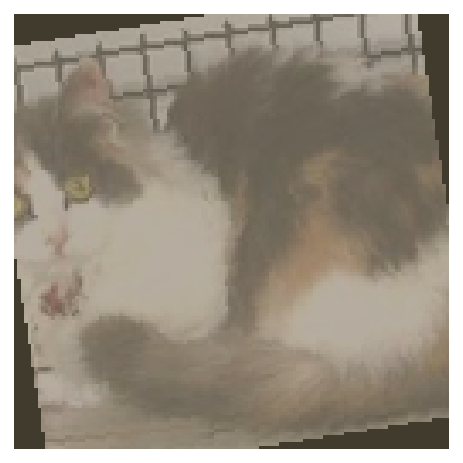

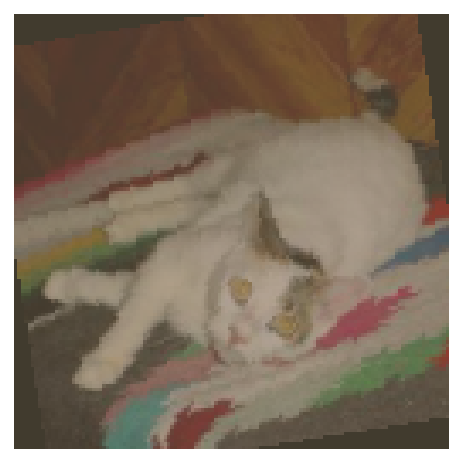

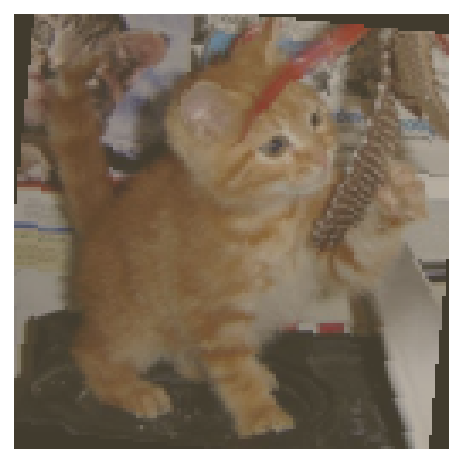

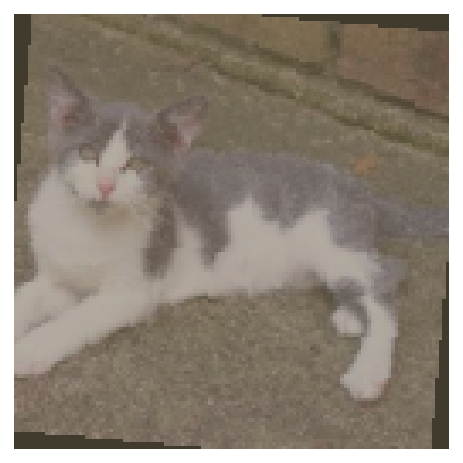

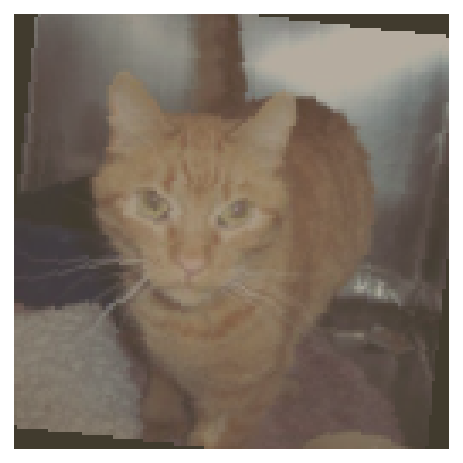

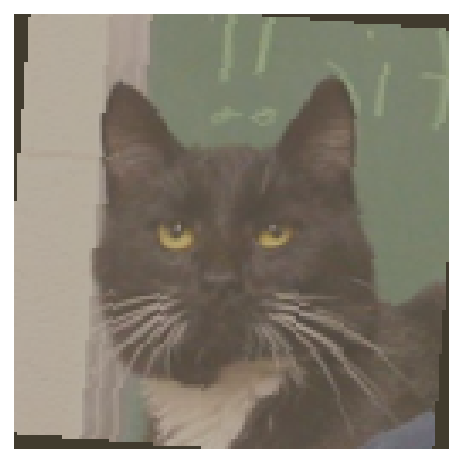

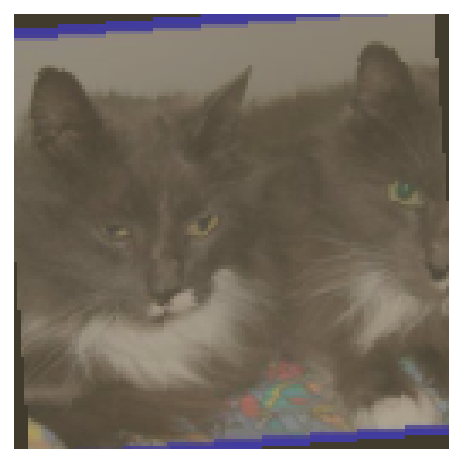

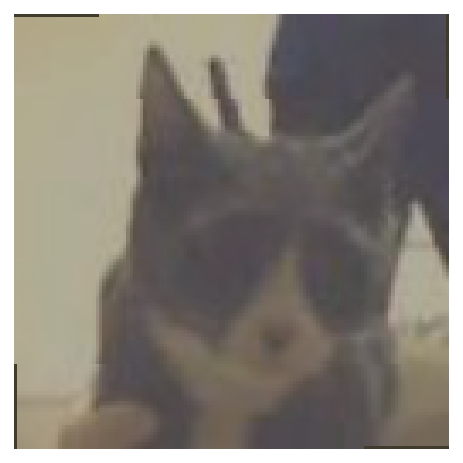

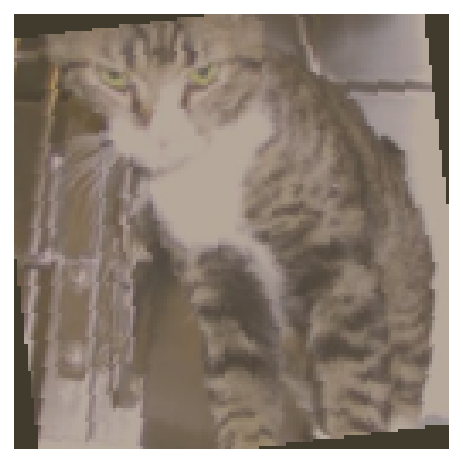

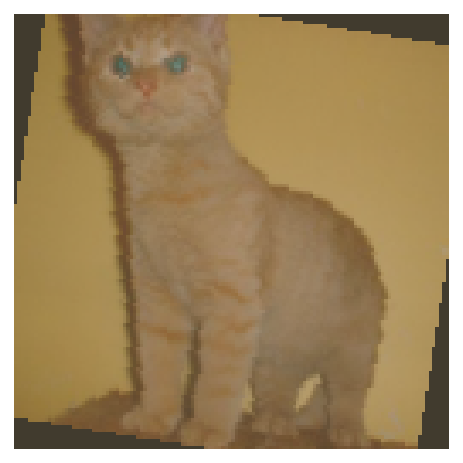

In [77]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
# if train_on_gpu:
#     images = images.cuda()

model.cpu()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    helper.imshow(images[idx])
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))